In [135]:
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt
import math
from scipy import stats
import statistics
import matplotlib as mpl
from matplotlib import rcParams
#import loompy as lp
#from MulticoreTSNE import MulticoreTSNE as TSNE
from matplotlib.pyplot import rc_context
from matplotlib import pyplot as plt 

In [2]:
adata = sc.read_h5ad('all_data_aggr_scanpy_v2.h5ad')

In [3]:
adata.obs['TimePoints'] = 'Adult'

In [4]:
adata.obs.loc[adata.obs['Sample'].isin(['8W_rep1','8W_rep2']),'TimePoints'] = 'Embryo'
adata.obs.loc[adata.obs['Sample'].isin(['12W_rep1','12W_rep2']),'TimePoints'] = 'Fetal'

In [5]:
pd.DataFrame(adata.obs.Sample.value_counts())

,count
Sample,
12W_rep1,10151
12W_rep2,7306
8W_rep1,4703
RL11,2765
8W_rep2,2576
RL13,2219
RL12,446


In [6]:
def identify_lineage_tracing(adata, timePoint_by, cluster_group, cellType_trace, min_cells_in_cluster=10):
    adata_list = {} # Making dictionary
    #adata_list = {group:adata[adata.obs['TimePoints'].isin([group])] }
    
        
    for group in adata.obs[timePoint_by].value_counts().index:
        #print(f"adata_{group}")
        print(f"{group}")
        adata_tmp = adata[adata.obs[timePoint_by].isin([group])]
        clusters_to_remove = adata_tmp.obs[cluster_group].value_counts().index[adata_tmp.obs[cluster_group].value_counts() < min_cells_in_cluster].values
        adata_tmp =  adata_tmp[~adata_tmp.obs[cluster_group].isin(clusters_to_remove.tolist()),:]
        adata_list[group] = adata_tmp
        sc.tl.rank_genes_groups(adata_list[group], groupby=cluster_group, method='wilcoxon')       
    
    
    
    return adata_list

In [7]:
adata_list = identify_lineage_tracing(adata, timePoint_by='TimePoints', 
                                      cluster_group='louvain_0.4', cellType_trace=['4','20'], min_cells_in_cluster=10)

Fetal


/home/mqbsxsm2/anaconda3/envs/r4/lib/python3.9/site-packages/anndata/_core/anndata.py:1222: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


Embryo


/home/mqbsxsm2/anaconda3/envs/r4/lib/python3.9/site-packages/anndata/_core/anndata.py:1222: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


Adult


/home/mqbsxsm2/anaconda3/envs/r4/lib/python3.9/site-packages/anndata/_core/anndata.py:1222: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


In [8]:
adata_list['Embryo'].obs['louvain_0.4'].value_counts()

louvain_0.4
2     2631
4     2141
7     1503
17     517
20     413
10      67
Name: count, dtype: int64

In [55]:
def calculate_marker_genes(adata_list, marker_gene_len=5000):
    de_results = {}
    for dc in adata_list:
        print(dc)
        result = adata_list[dc].uns['rank_genes_groups']
        groups = result['names'].dtype.names
        de_results[dc] = pd.DataFrame(
                                {group + '_' + key[:1]: result[key][group]
                                    for group in groups for key in ['names', 'pvals','logfoldchanges']}).head(marker_gene_len)
        
    return de_results


In [61]:
de_results = calculate_marker_genes(adata_list, marker_gene_len=5000)

Fetal
Embryo
Adult


In [147]:
def calculate_lineage(geneNames, de_results, source_timepoint, target_timepoint, source_cluster, source_gene_num=100, target_gene_number=500):
    
    geneName = geneNames[0]
    res = de_results[target_timepoint][de_results[target_timepoint].isin(geneName)].stack(0)    
    source_to_target = res.reset_index(level=[0,1])
 
    for i in range(1,geneNames.shape[0]):
        geneName = geneNames[i]
        res = de_results[target_timepoint][de_results[target_timepoint].isin(geneName)].stack(0)    
        source_to_target=pd.concat([source_to_target,res.reset_index(level=[0,1])], ignore_index=True)
    
    source_to_target.rename(columns={'level_0':'row_rank','level_1':'cluster',0:'gene'}, inplace=True)
    
    return source_to_target

In [105]:
geneNames = de_results[source_timepoint][[source_cluster]].iloc[0:100].values
geneNames.shape

(100, 1)

In [86]:
fet_to_adult = calculate_lineage(geneNames, de_results, source_timepoint = 'Embryo',target_timepoint = 'Adult', source_cluster = '20_n')

In [87]:
fet_to_adult

,row_rank,cluster,gene
0,31,11_n,TNS3
1,1358,11_n,FRMD4A
2,2218,0_n,FRMD4A
3,823,0_n,PRDM6
4,0,0_n,PRKG1
...,...,...,...
136,185,0_n,PBX1
137,574,0_n,PCDH7
138,1,18_n,ST6GALNAC3
139,1501,11_n,ST6GALNAC3


In [91]:
def get_mapped_gene_number(df_s_to_t,clusterName, group_by='cluster'):
    grouped = df_s_to_t.groupby([group_by])
    df1 = grouped.get_group(clusterName)
    return df1.shape[0]

In [92]:
get_mapped_gene_number(fet_to_adult, clusterName='0_n')

81

In [155]:
def get_bootstrap_numbers(iter=100):
    mapped_gene_number = np.array([])
    all_embryo_gene = adata.var.index
    for i in range(1,iter):
        geneNames = np.reshape(np.random.choice(all_embryo_gene, size=100), (-1,1))
        fet_to_adult = calculate_lineage(geneNames, de_results, source_timepoint = 'Embryo',target_timepoint = 'Adult', source_cluster = '20_n')
        mapCount = get_mapped_gene_number(fet_to_adult, clusterName='0_n')
        mapped_gene_number = np.append(mapped_gene_number,mapCount)
        
    return mapped_gene_number

In [156]:
mapped_gene_number = get_bootstrap_numbers(iter=10000)

In [157]:
#np.histogram(a,bins = [0,20,40,60,80,100]) 
hist,bins = np.histogram(mapped_gene_number,bins = 30) 
print(hist)
print(bins)

[   3    2    4   12   20  104  124  157  225  299  897  615  657  747
  747 1637  738  633  618  468  636  219  150  103   70   74   15   17
    5    3]
[24.  25.2 26.4 27.6 28.8 30.  31.2 32.4 33.6 34.8 36.  37.2 38.4 39.6
 40.8 42.  43.2 44.4 45.6 46.8 48.  49.2 50.4 51.6 52.8 54.  55.2 56.4
 57.6 58.8 60. ]


In [158]:
np.percentile(mapped_gene_number, [2.5,97.5])# 95% C.I.

array([32., 52.])

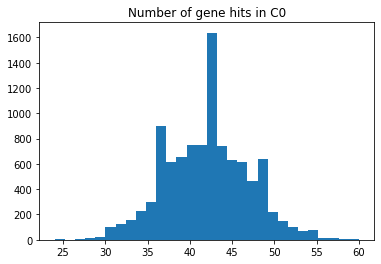

<Figure size 432x288 with 0 Axes>

In [165]:
plt.hist(mapped_gene_number, bins=30) 
plt.title("Number of gene hits in C0") 
plt.show()
plt.savefig('C0_genehits_hist.png')

In [164]:
geneNames = de_results[source_timepoint][[source_cluster]].iloc[0:100].values
fet_to_adult = calculate_lineage(geneNames, de_results, source_timepoint = 'Embryo',target_timepoint = 'Adult', source_cluster = '20_n')
mapCount = get_mapped_gene_number(fet_to_adult, clusterName='0_n')
mapCount

81

In [34]:
de_results['Embryo'].columns

Index(['2_n', '2_p', '2_l', '4_n', '4_p', '4_l', '7_n', '7_p', '7_l', '10_n',
       '10_p', '10_l', '17_n', '17_p', '17_l', '20_n', '20_p', '20_l'],
      dtype='object')

In [14]:
geneName = de_results_embryo[['20_n']].iloc[0].values
res = de_results_adult[de_results_adult.isin(geneName)].stack(0)    
fet_to_adult = res.reset_index(level=[0,1])
 
for i in range(1,de_results_embryo[['20_n']].shape[0]):
    geneName = de_results_embryo[['20_n']].iloc[i].values
    res = de_results_adult[de_results_adult.isin(geneName)].stack(0)    
    fet_to_adult=pd.concat([fet_to_adult,res.reset_index(level=[0,1])], ignore_index=True)
    
fet_to_adult.rename(columns={'level_0':'row_rank','level_1':'cluster',0:'gene'}, inplace=True)

In [15]:
fet_to_adult

,row_rank,cluster,gene
0,31,11_n,TNS3
1,1358,11_n,FRMD4A
2,2218,0_n,FRMD4A
3,823,0_n,PRDM6
4,0,0_n,PRKG1
...,...,...,...
136,185,0_n,PBX1
137,574,0_n,PCDH7
138,1,18_n,ST6GALNAC3
139,1501,11_n,ST6GALNAC3


In [16]:
fet_to_adult.cluster.value_counts()

cluster
0_n     81
18_n    33
16_n    14
11_n    13
Name: count, dtype: int64

In [17]:
fet_to_adult.gene.value_counts().index[fet_to_adult.gene.value_counts() <2]

Index(['GRID2', 'COL27A1', 'PRR16', 'COL21A1', 'OGN', 'UNC5C', 'ADGRL3',
       'FBLN5', 'PTGIS', 'PBX1', 'EGFR', 'PRKD1', 'PDE5A', 'GRIP1', 'PCDH7',
       'COL1A1', 'SORCS1', 'TMEM117', 'EFNB2', 'NPAS3', 'ANKRD44', 'MYH10',
       'MEG3', 'EPHB2', 'COL14A1', 'TNS3', 'LRRN1', 'IL1RAPL1', 'PDE3A',
       'PDGFRB', 'SLIT3', 'GRM7', 'PTPRD', 'APBB2', 'KCNQ1OT1', 'ADGRB3',
       'SH3PXD2B', 'GPC6', 'EFNA5', 'MEIS1', 'SLIT2', 'FOXP2', 'PRKG1',
       'PRDM6', 'NFIA', 'ROBO1', 'SMOC2', 'EDNRA', 'ANOS1', 'THSD7A', 'ELN',
       'EXT1', 'COL5A1', 'MAP2', 'ZFHX4', 'GPC5', 'BOC', 'CNTNAP3B', 'CPE',
       'MEST', 'CADM2', 'LRRTM4', 'KAZN', 'AC092691.1'],
      dtype='object', name='gene')

In [18]:
grouped = fet_to_adult.groupby(['cluster'])
df1 = grouped.get_group("0_n")
df1

,row_rank,cluster,gene
2,2218,0_n,FRMD4A
3,823,0_n,PRDM6
4,0,0_n,PRKG1
5,246,0_n,FOXP2
6,1030,0_n,LRP1B
...,...,...,...
132,397,0_n,GMDS
134,526,0_n,PTGIS
135,379,0_n,MYH10
136,185,0_n,PBX1


In [19]:
df1[df1.gene.isin(fet_to_adult.gene.value_counts().index[fet_to_adult.gene.value_counts() <2])].head()

,row_rank,cluster,gene
3,823,0_n,PRDM6
4,0,0_n,PRKG1
5,246,0_n,FOXP2
8,97,0_n,SLIT2
9,274,0_n,MEIS1


In [20]:
df1[df1.gene.isin(fet_to_adult.gene.value_counts().index[fet_to_adult.gene.value_counts() <2])].shape

(56, 3)

In [256]:
res = de_results_fetal[de_results_fetal.isin(['PRDM6'])].stack(0)
res

2     9_n     PRDM6
231   6_n     PRDM6
300   17_n    PRDM6
2109  21_n    PRDM6
3533  12_n    PRDM6
dtype: object

In [265]:
res.reset_index(level=[0,1])

,level_0,level_1,0
0,2,9_n,PRDM6
1,231,6_n,PRDM6
2,300,17_n,PRDM6
3,2109,21_n,PRDM6
4,3533,12_n,PRDM6


In [76]:
adata_list

{'Fetal': View of AnnData object with n_obs × n_vars = 17457 × 11900
     obs: 'batch', 'Sample', 'sum', 'detected', 'percent_top_50', 'percent_top_100', 'percent_top_200', 'percent_top_500', 'subsets_Mt_sum', 'subsets_Mt_detected', 'subsets_Mt_percent', 'total', 'CellCycle', 'sizeFactor', 'Clusters', 'graphClusters', 'cellType', 'Barcode', 'CellType', 'label', 'hclust', 'walktrap', 'louvain', 'replicate', 'condition', 'sex', 'merged.walktrap', 'merged.louvain', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb', 'percent_chrY', 'n_counts', 'leiden', 'leiden_1.0', 'louvain_1.0', 'leiden_0.4', 'louvain_0.4', 'leiden_0.2', 'louvain_0.2', 'leiden_0.1', 'louvain_0.1', 'umap_density_Sample', 'TimePoints'
     var: 'mean-0', 'detected-0', 'n_cells_by_counts-0', 'pct_dropout-0', 'PercentClust1-0', 'PercentClust2-0', 'PercentClust3-0', 'PercentClust4-0', 'PercentClust5-0', 'PercentClust6-0', 'Perce